In [47]:
!pip install diffusers transformers accelerate adversarial-robustness-toolbox

import os
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from diffusers import Transformer2DModel, AutoencoderKL, DDPMScheduler
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ({torch.cuda.device_count()} GPUs available)")

Using device: cuda (2 GPUs available)


In [62]:
BATCH_SIZE = 64

TRAIN_ROOT = '/kaggle/input/imagenet100/train.X1'
VAL_ROOT   = '/kaggle/input/imagenet100/val.X'

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    root=TRAIN_ROOT,
    transform=transform_train
)

print("Filtering Validation Set...")
full_test_dataset = torchvision.datasets.ImageFolder(
    root=VAL_ROOT,
    transform=transform_test
)

train_classes = set(train_dataset.classes)
test_classes = full_test_dataset.classes

valid_indices = []
test_to_train_map = {} 

for i, (path, test_label_idx) in enumerate(full_test_dataset.samples):
    class_name = test_classes[test_label_idx]
    
    if class_name in train_classes:
        valid_indices.append(i)
        train_label_idx = train_dataset.class_to_idx[class_name]
        test_to_train_map[test_label_idx] = train_label_idx

test_dataset = Subset(full_test_dataset, valid_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Data Ready.")
print(f"Training classes: {len(train_dataset.classes)}")
print(f"Test images (Filtered): {len(test_dataset)}")

Filtering Validation Set...
Data Ready.
Training classes: 25
Test images (Filtered): 1250


In [ ]:
print("Loading ResNet-18...")

# allows the model to accept raw images in [0, 1] range
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor(std).view(1, 3, 1, 1))

    def forward(self, x):
        return (x - self.mean) / self.std

base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = base_model.fc.in_features

# changing final layer to predict specific number of classes based on dataset
num_classes = len(train_dataset.classes)
base_model.fc = nn.Linear(num_ftrs, num_classes)

baseline_model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    base_model
)

baseline_model = baseline_model.to(device)
print(f"Model initialized for {num_classes} classes.")

Loading ResNet-18...
Model initialized for 25 classes.


In [50]:
def train_model(model, train_loader, optimizer, loss_fn, epochs):
    model.train()
    print(f"Starting training for {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += data.size(0)

        print(f"Epoch {epoch:02d} | Loss: {running_loss/total:.4f} | Acc: {100.0*correct/total:.2f}%")

In [51]:
EPOCHS = 10
LEARNING_RATE = 0.01

optimizer = optim.SGD(baseline_model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

model_save_path = "models/resnet18_25classes.pth"
os.makedirs("models", exist_ok=True)

train_model(baseline_model, train_loader, optimizer, loss_fn, EPOCHS)
torch.save(baseline_model.state_dict(), model_save_path)
print("Training Complete.")

Starting training for 10 epochs...
Epoch 01 | Loss: 0.3547 | Acc: 89.29%
Epoch 02 | Loss: 0.2205 | Acc: 92.85%
Epoch 03 | Loss: 0.1822 | Acc: 94.04%
Epoch 04 | Loss: 0.1502 | Acc: 94.97%
Epoch 05 | Loss: 0.1284 | Acc: 95.66%
Epoch 06 | Loss: 0.1133 | Acc: 96.30%
Epoch 07 | Loss: 0.0991 | Acc: 96.76%
Epoch 08 | Loss: 0.0973 | Acc: 96.82%
Epoch 09 | Loss: 0.0922 | Acc: 96.93%
Epoch 10 | Loss: 0.0765 | Acc: 97.45%
Training Complete.


In [52]:
classifier_art = PyTorchClassifier(
    model=baseline_model,
    loss=nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape=(3, 224, 224),
    nb_classes=len(train_dataset.classes),
    clip_values=(0.0, 1.0),
    device_type=device.type
)

pgd_attack = ProjectedGradientDescent(
    estimator=classifier_art,
    eps=8/255,
    eps_step=2/255,
    max_iter=10,
    batch_size=BATCH_SIZE,
    verbose=False
)

print("Generating Adversarial Examples...")
adv_imgs, clean_imgs, labels_list = [], [], []

for i, (imgs, raw_labels) in enumerate(test_loader):
    if i >= 5: break 
    
    mapped_labels = torch.tensor([test_to_train_map[l.item()] for l in raw_labels])
    
    imgs_np = imgs.cpu().numpy().astype(np.float32)
    adv_batch = pgd_attack.generate(x=imgs_np, y=mapped_labels.numpy())
    
    adv_imgs.append(adv_batch)
    clean_imgs.append(imgs_np)
    labels_list.append(mapped_labels.numpy())

x_adv = np.concatenate(adv_imgs)
x_clean = np.concatenate(clean_imgs)
y_true_train_ids = np.concatenate(labels_list)

print(f"Generated {len(x_adv)} adversarial images (Labels mapped to 0-24).")

Generating Adversarial Examples...
Generated 320 adversarial images (Labels mapped to 0-24).


In [ ]:
# helper class to handle  output format of DiT model
class DiTWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, hidden_states, timestep, class_labels):
        output = self.model(hidden_states, timestep=timestep, class_labels=class_labels).sample
        if output.shape[1] == 8: output, _ = output.chunk(2, dim=1)
        return output

print("Loading DiT & VAE...")

# compress large images into smaller represntation for faster diffusion
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to(device)
vae.requires_grad_(False)

base_transformer = Transformer2DModel.from_pretrained("facebook/DiT-XL-2-256", subfolder="transformer", torch_dtype=torch.float16).to(device)
base_transformer.requires_grad_(False)

# multi GPU support
if torch.cuda.device_count() > 1:
    print(f"DataParallel: {torch.cuda.device_count()} GPUs")
    transformer = nn.DataParallel(DiTWrapper(base_transformer))
else:
    transformer = DiTWrapper(base_transformer).to(device)

scheduler = DDPMScheduler.from_pretrained("facebook/DiT-XL-2-256", subfolder="scheduler")

Loading DiT & VAE...


An error occurred while trying to fetch facebook/DiT-XL-2-256: facebook/DiT-XL-2-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DataParallel: 2 GPUs


In [54]:
@torch.no_grad()
def purify_image(image_tensor, vae, transformer, scheduler, timestep_strength, labels):
    image_tensor = image_tensor.to(device).half()
    labels = labels.to(device)

    x = torch.nn.functional.interpolate(image_tensor, size=(256, 256), mode='bilinear', align_corners=False)
    x = (x * 2.0) - 1.0

    latents = vae.encode(x).latent_dist.sample() * vae.config.scaling_factor

    scheduler.set_timesteps(100)
    t_start = int((timestep_strength / 100.0) * 100)
    noise = torch.randn_like(latents)
    timesteps = torch.tensor([t_start], device=device).long()
    noisy_latents = scheduler.add_noise(latents, noise, timesteps)
    
    current_latents = noisy_latents
    inference_steps = scheduler.timesteps[scheduler.timesteps < t_start]

    for t in inference_steps:
        t_batch = torch.full((current_latents.size(0),), t, device=device, dtype=torch.long)
        model_output = transformer(current_latents, t_batch, class_labels=labels)
        current_latents = scheduler.step(model_output, t, current_latents).prev_sample

    image_decoded = vae.decode(current_latents / vae.config.scaling_factor).sample
    image_decoded = (image_decoded / 2.0) + 0.5
    image_final = torch.nn.functional.interpolate(image_decoded, size=(224, 224), mode='bilinear', align_corners=False)
    
    return torch.clamp(image_final, 0, 1)

In [ ]:
# translating local IDs to global ImageNet IDs
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet1k_indices = requests.get(url).json()
wnid_to_global = {wnid: int(idx) for idx, (wnid, _) in imagenet1k_indices.items()}

# translation map tensor
train_to_global_map = [wnid_to_global.get(wnid, 0) for wnid in train_dataset.classes]
train_to_global_tensor = torch.tensor(train_to_global_map, device=device)

PURIFICATION_T = 75
BATCH_SIZE = 32

adv_tensor = torch.tensor(x_adv)
label_tensor = torch.tensor(y_true_train_ids)

print(f"Purifying {len(adv_tensor)} images (t={PURIFICATION_T})...")
purified_list = []

for i in range(0, len(adv_tensor), BATCH_SIZE):
    batch = adv_tensor[i:i+BATCH_SIZE]
    lbls_train_id = label_tensor[i:i+BATCH_SIZE].to(device)
    
    lbls_global = train_to_global_tensor[lbls_train_id]
    
    purified = purify_image(batch, vae, transformer, scheduler, PURIFICATION_T, lbls_global)
    purified_list.append(purified.cpu().float())
    
    if i % (BATCH_SIZE*2) == 0: print(f"Processed {i}...")

purified_all = torch.cat(purified_list)

baseline_model.eval()
with torch.no_grad():
    dataset = torch.utils.data.TensorDataset(purified_all, label_tensor.cpu())
    loader = DataLoader(dataset, batch_size=64)
    
    correct = 0
    for img, lbl in loader:
        out = baseline_model(img.to(device))
        pred = out.argmax(1)
        correct += (pred == lbl.to(device)).sum().item()

acc = 100 * correct / len(purified_all)
print(f"Final Purification Accuracy: {acc:.2f}%")

Purifying 320 images (t=75)...
Processed 0...
Processed 64...
Processed 128...
Processed 192...
Processed 256...
Final Purification Accuracy: 61.56%


Calculating final metrics...
Clean: 92.2% | Adversarial: 0.0% | Purified: 61.6%


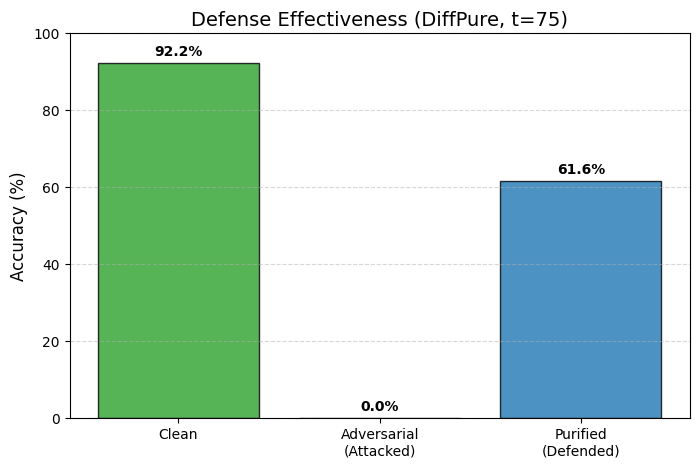


Visual Comparison: Clean vs. Adversarial vs. Purified


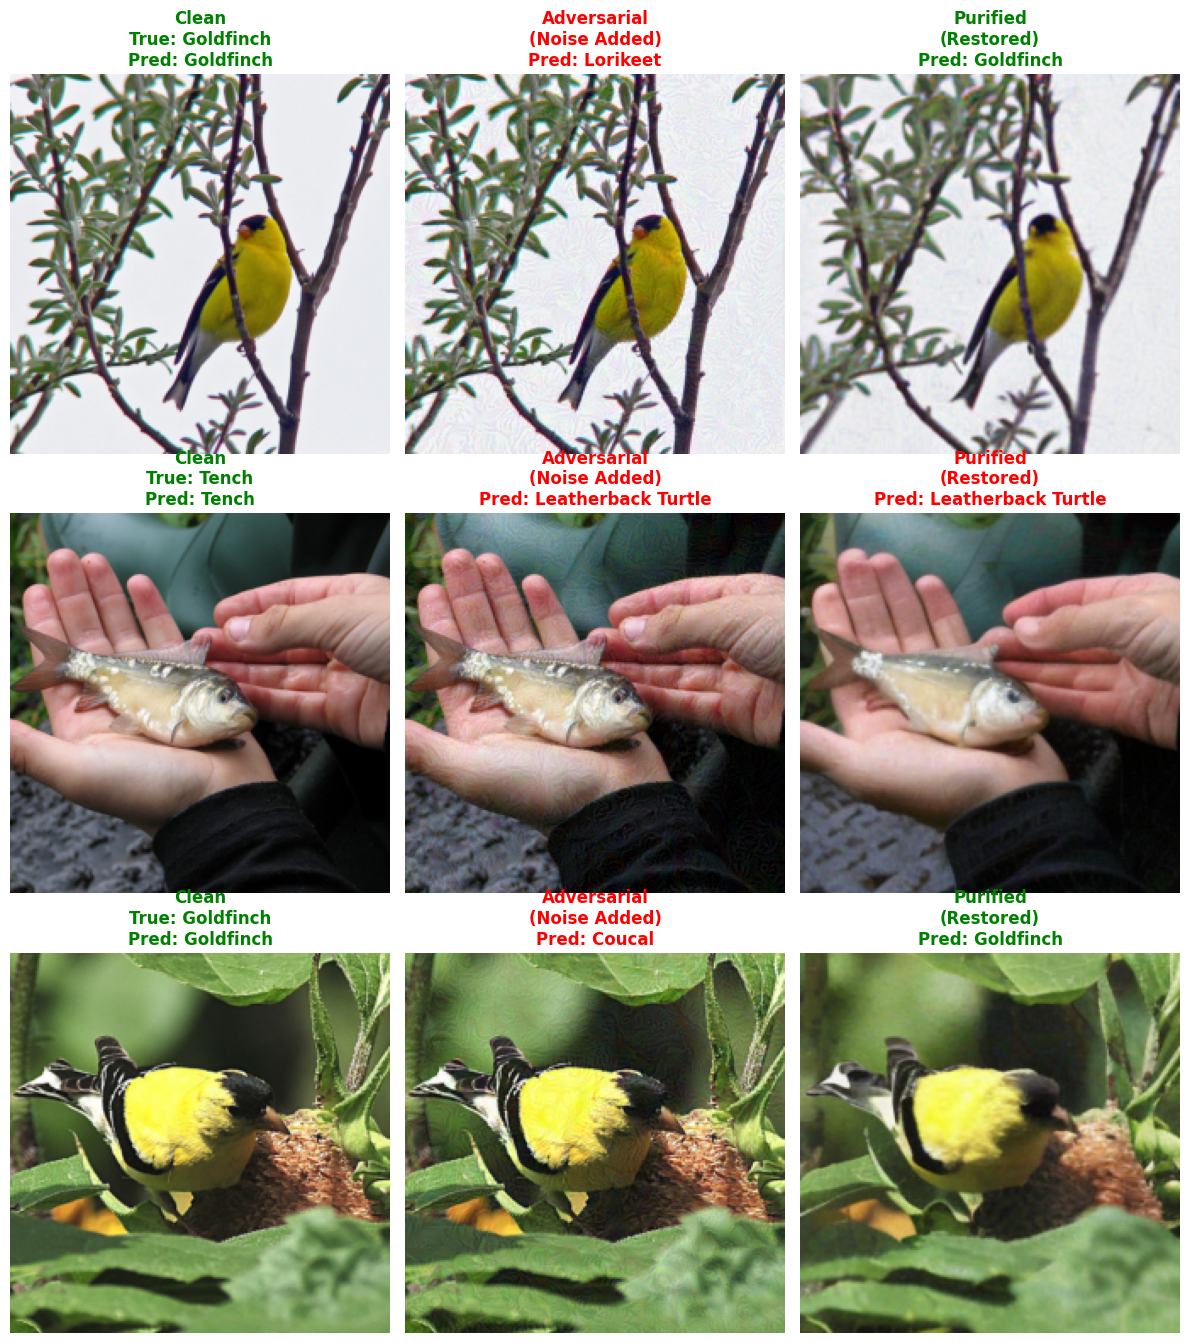

In [59]:
import matplotlib.pyplot as plt

wnid_to_name = {}
for idx_str, (wnid, name) in imagenet1k_indices.items():
    wnid_to_name[wnid] = name

def get_name(local_label_idx):
    wnid = train_dataset.classes[local_label_idx]
    return wnid_to_name.get(wnid, "Unknown").replace("_", " ").title()

print("Calculating final metrics...")
baseline_model.eval()
with torch.no_grad():
    clean_tensor = torch.tensor(x_clean).to(device)
    labels_tensor = torch.tensor(y_true_train_ids).to(device)
    pred_clean = baseline_model(clean_tensor).argmax(1)
    acc_clean = (pred_clean == labels_tensor).float().mean().item() * 100

    adv_tensor = torch.tensor(x_adv).to(device)
    pred_adv = baseline_model(adv_tensor).argmax(1)
    acc_adv = (pred_adv == labels_tensor).float().mean().item() * 100

print(f"Clean: {acc_clean:.1f}% | Adversarial: {acc_adv:.1f}% | Purified: {acc:.1f}%")

plt.figure(figsize=(8, 5))
metrics = ['Clean', 'Adversarial\n(Attacked)', 'Purified\n(Defended)']
values = [acc_clean, acc_adv, acc]
colors = ['#2ca02c', '#d62728', '#1f77b4']

bars = plt.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Defense Effectiveness (DiffPure, t={PURIFICATION_T})', fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2, 
             f'{height:.1f}%', ha='center', fontweight='bold')
plt.show()

print("\nVisual Comparison: Clean vs. Adversarial vs. Purified")

def show_images_with_names(indices):
    fig, axes = plt.subplots(len(indices), 3, figsize=(12, 4.5 * len(indices)))
    
    for i, idx in enumerate(indices):
        img_c = x_clean[idx].transpose(1, 2, 0)
        img_a = x_adv[idx].transpose(1, 2, 0)
        img_p = purified_all[idx].permute(1, 2, 0).cpu().numpy()
        
        true_lbl = y_true_train_ids[idx]
        true_name = get_name(true_lbl)
        
        pc = pred_clean[idx].item()
        pa = pred_adv[idx].item()
        with torch.no_grad():
            pp = baseline_model(purified_all[idx:idx+1].to(device)).argmax(1).item()
            
        name_c = get_name(pc)
        name_a = get_name(pa)
        name_p = get_name(pp)

        col_c = 'green' if pc == true_lbl else 'red'
        col_a = 'green' if pa == true_lbl else 'red'
        col_p = 'green' if pp == true_lbl else 'red'

        axes[i, 0].imshow(np.clip(img_c, 0, 1))
        axes[i, 0].set_title(f"Clean\nTrue: {true_name}\nPred: {name_c}", color=col_c, fontweight='bold')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.clip(img_a, 0, 1))
        axes[i, 1].set_title(f"Adversarial\n(Noise Added)\nPred: {name_a}", color=col_a, fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(np.clip(img_p, 0, 1))
        axes[i, 2].set_title(f"Purified\n(Restored)\nPred: {name_p}", color=col_p, fontweight='bold')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

random_indices = np.random.choice(len(x_adv), 3, replace=False)
show_images_with_names(random_indices)